In [68]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [12]:
# Function to extract landmarks (i.e. important points) from an image
def extract_landmarks(image_path):
    mp_drawing = mp.solutions.drawing_utils
    mp_pose = mp.solutions.pose

    # Reading the image
    frame = cv2.imread(image_path)
    # Converting the image from BGR color (which OpenCV uses) to RGB color
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Initializing MediaPipe Pose.
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

    # Getting the output from running the MediaPipe Pose model.
    results = pose.process(frame)

    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        return landmarks
    else:
        print("No pose landmarks detected.")
        return None


In [11]:
# Example: getting the landmarks from an image
landmarks = extract_landmarks('images/correct_seq/cor_down_1_38.jpg')

Establishing, the for loop to run through the frames.

In [1]:
# video indices

video_index_corr = [1, 2, 3, 4, 5, 6, 7, 47, 78, 79, 80, 83, 85, 100, 101, 102, 113, 114, 115, 116, 127, 129, 131, 132, 133
                , 134, 135, 136, 137, 138, 140, 141, 142, 144, 146, 147, 148, 162, 163, 164, 165, 173, 174, 175, 177, 178, 186, 187, 188, 197]
# no 176 after all

video_index_incorr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 36, 37, 42, 44,
                46, 55,56,57,58,81,104,105, 107, 108, 110, 149, 150, 151, 152, 153, 155, 156, 166, 167, 168, 171, 198]


In [23]:
# Establishing which frame position we want, manually.
up_down = 'down' # 'up' or 'down'

# Establishing which label we want, manually.
label = 'correct' # 'correct' or 'incorrect'

if label == 'correct':
    image_dir = 'images/correct_seq'
    corr_inc = 'cor'
    video_indices = video_index_corr
elif label == 'incorrect':
    image_dir = 'images/wrong_seq'
    corr_inc = 'inc'
    video_indices = video_index_incorr
else:
    print('Label not found')
    exit()


# Looping over the video indices
for video_index in video_indices:
    # Constructing the file pattern using the video index
    file_pattern = f'{corr_inc}_{up_down}_{video_index}_*.jpg'
    file_pattern_path = os.path.join(image_dir, file_pattern)
    # Finding the file that matches the pattern
    matching_files = glob.glob(file_pattern_path)
    # There should be only one
    file_path = matching_files[0]

    print(file_path)

    # Here we do the image processing
    # Read the image
    #img = cv2.imread(file_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Extracting the landmarks from the image
    #landmarks = extract_landmarks(file_path)

images/correct_seq/cor_down_1_38.jpg
images/correct_seq/cor_down_2_23.jpg
images/correct_seq/cor_down_3_22.jpg
images/correct_seq/cor_down_4_19.jpg
images/correct_seq/cor_down_5_19.jpg
images/correct_seq/cor_down_6_19.jpg
images/correct_seq/cor_down_7_25.jpg
images/correct_seq/cor_down_47_31.jpg
images/correct_seq/cor_down_78_25.jpg
images/correct_seq/cor_down_79_22.jpg
images/correct_seq/cor_down_80_109.jpg
images/correct_seq/cor_down_83_40.jpg
images/correct_seq/cor_down_85_34.jpg
images/correct_seq/cor_down_100_82.jpg
images/correct_seq/cor_down_101_31.jpg
images/correct_seq/cor_down_102_41.jpg
images/correct_seq/cor_down_113_31.jpg
images/correct_seq/cor_down_114_41.jpg
images/correct_seq/cor_down_115_85.jpg
images/correct_seq/cor_down_116_19.jpg
images/correct_seq/cor_down_127_52.jpg
images/correct_seq/cor_down_129_46.jpg
images/correct_seq/cor_down_131_25.jpg
images/correct_seq/cor_down_132_28.jpg
images/correct_seq/cor_down_133_25.jpg
images/correct_seq/cor_down_134_22.jpg
image

In [9]:
# extracting the landmarks from the image
landmarks = extract_landmarks('images/correct_seq/cor_down_1_38.jpg')

# printing the landmarks
print(landmarks)

landmarks[0].x

[x: 0.7661074995994568
y: 0.8698264956474304
z: 0.019169768318533897
visibility: 0.999934196472168
, x: 0.7786078453063965
y: 0.8538932800292969
z: 0.03297549858689308
visibility: 0.9999415874481201
, x: 0.778795599937439
y: 0.8499230146408081
z: 0.032893482595682144
visibility: 0.999945878982544
, x: 0.7791699767112732
y: 0.8454272747039795
z: 0.03279905393719673
visibility: 0.9999591112136841
, x: 0.778984785079956
y: 0.8549779057502747
z: -0.010449687950313091
visibility: 0.9999418258666992
, x: 0.7792743444442749
y: 0.8520131707191467
z: -0.010508530773222446
visibility: 0.9999560117721558
, x: 0.7797145843505859
y: 0.8485186100006104
z: -0.01050341036170721
visibility: 0.9999649524688721
, x: 0.7729354500770569
y: 0.8109787106513977
z: 0.1204240471124649
visibility: 0.9999657869338989
, x: 0.7731179594993591
y: 0.8203222751617432
z: -0.07692527025938034
visibility: 0.9999438524246216
, x: 0.7524489164352417
y: 0.8575229048728943
z: 0.0576862171292305
visibility: 0.9998754262924194

0.7661074995994568

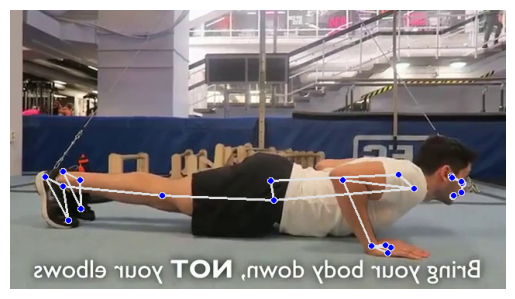

In [41]:
def extract_landmarks(image_path):
    mp_drawing = mp.solutions.drawing_utils
    mp_pose = mp.solutions.pose

    # Read the image and convert it to RGB
    frame = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Initialize MediaPipe Pose.
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

    # Process the image to extract pose landmarks.
    results = pose.process(frame)

    if results.pose_landmarks:
        # Draw landmarks
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
        # Annotate landmarks with their index numbers
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            # Convert normalized landmark coordinates to pixel values
            landmark_px = [int(landmark.x * frame.shape[1]), int(landmark.y * frame.shape[0])]
            
            # Use cv2.putText to draw the index number

            #cv2.putText(frame, str(idx), (landmark_px[0], landmark_px[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1, cv2.LINE_AA)
        
        return frame
    else:
        print("No pose landmarks detected.")
        return None

def display_image(image):
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()

# Use your function with an example image:
image_with_landmarks = extract_landmarks('images/correct_seq/cor_down_47_31.jpg')
if image_with_landmarks is not None:
    display_image(image_with_landmarks)

In [ ]:
images/correct_seq/cor_down_3_22.jpg
images/correct_seq/cor_down_4_19.jpg
images/correct_seq/cor_down_5_19.jpg
images/correct_seq/cor_down_6_19.jpg
images/correct_seq/cor_down_7_25.jpg
images/correct_seq/cor_down_47_31.jpg
images/correct_seq/cor_down_78_25.jpg
images/correct_seq/cor_down_79_22.jpg

In [64]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image


In [73]:
model_path = 'pose_landmarker_heavy.task'

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE)

with PoseLandmarker.create_from_options(options) as landmarker:
    # Load the input image from an image file.
    image = mp.Image.create_from_file('images/correct_seq/cor_down_80_109.jpg')

    
    # Perform pose landmarking on the provided single image.
    # The pose landmarker must be created with the image mode.
    pose_landmarker_result = landmarker.detect(image)

    pose_landmarks_list = pose_landmarker_result.pose_landmarks

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])

# printing the 3d coordinates of the first landmark
print(pose_landmarks_list[0][0].x)
print(pose_landmarks_list[0][0].y)
print(pose_landmarks_list[0][0].z)

# now the second landmark
print(pose_landmarks_list[0][1].x)
print(pose_landmarks_list[0][1].y)
print(pose_landmarks_list[0][1].z)


0.9436929225921631
0.6891990900039673
0.02424878254532814
0.9459939002990723
0.6607023477554321
0.03690794110298157


In [77]:
pose_landmarks_list[0][0]

NormalizedLandmark(x=0.9436929225921631, y=0.6891990900039673, z=0.02424878254532814, visibility=0.9999299049377441, presence=0.9999715089797974)

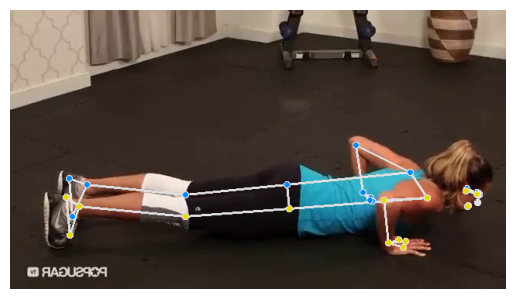

In [72]:
annotated_image = draw_landmarks_on_image(image.numpy_view(), pose_landmarker_result)
plt.imshow(annotated_image)
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
# getting 

In [58]:
image_path = 'images/correct_seq/cor_down_3_22.jpg'
landmarks = extract_landmarks(image_path)

image = cv2.imread(image_path)
display_image_with_landmarks(image, landmarks)


TypeError: object of type 'NormalizedLandmarkList' has no len()